In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re


In [4]:
fld = open(os.path.join("e:/", "LD2011_2014.txt"), "r")

data=[]
cid=250

for line in fld:
    if line.startswith("\"\";"):
        continue
    cols = [float(re.sub(",",".", x)) for x in line.strip().split(";")[1:]]
    data.append(cols[cid])
fld.close()

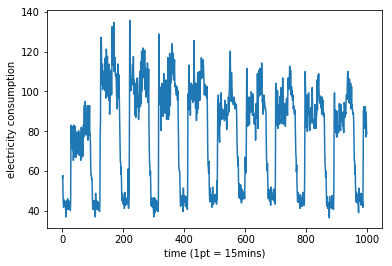

In [5]:
NUM_ENTRIES = 1000
plt.plot(range(NUM_ENTRIES), data[:NUM_ENTRIES])
plt.xlabel("time (1pt = 15mins)")
plt.ylabel("electricity consumption")
plt.show()

In [38]:
np.save(os.path.join("./data", "LD_250.npy"), np.array(data))

In [39]:
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
import math

In [40]:
data = np.load(os.path.join("./data", "LD_250.npy"))

In [41]:
data[0]

array([ 0.37875314])

In [42]:
data[:10]

array([[ 0.37875314],
       [ 0.38970776],
       [ 0.32776504],
       [ 0.29137096],
       [ 0.28041635],
       [ 0.30592859],
       [ 0.29864978],
       [ 0.28773156],
       [ 0.28409215],
       [ 0.29864978]])

In [43]:
data.shape

(140256, 1)

In [44]:
data = data.reshape(-1,1)

In [45]:
data.shape

(140256, 1)

In [46]:
scaler = MinMaxScaler(feature_range=(0,1), copy=False)
data = scaler.fit_transform(data)

In [47]:
data.shape

(140256, 1)

In [48]:
data[:10]

array([[ 0.37875314],
       [ 0.38970776],
       [ 0.32776504],
       [ 0.29137096],
       [ 0.28041635],
       [ 0.30592859],
       [ 0.29864978],
       [ 0.28773156],
       [ 0.28409215],
       [ 0.29864978]])

In [49]:
NUM_TIMESTEPS=20

X = np.zeros((data.shape[0], NUM_TIMESTEPS))
Y = np.zeros((data.shape[0], 1))

for i in range(len(data) - NUM_TIMESTEPS -1):
    X[i] = data[i:i+NUM_TIMESTEPS].T
    Y[i] = data[i+NUM_TIMESTEPS+1]

X = np.expand_dims(X,axis=2)

In [50]:
X.shape

(140256, 20, 1)

In [ ]:
X[-1]

In [51]:
Y.shape

(140256, 1)

In [52]:
X[0]

array([[ 0.37875314],
       [ 0.38970776],
       [ 0.32776504],
       [ 0.29137096],
       [ 0.28041635],
       [ 0.30592859],
       [ 0.29864978],
       [ 0.28773156],
       [ 0.28409215],
       [ 0.29864978],
       [ 0.28773156],
       [ 0.26221931],
       [ 0.24766168],
       [ 0.30228919],
       [ 0.29501037],
       [ 0.27677694],
       [ 0.27313753],
       [ 0.309568  ],
       [ 0.29137096],
       [ 0.27677694]])

In [53]:
Y[0]

array([ 0.30228919])

In [54]:
sp = int(0.7*len(data))

In [55]:
Xtrain,Xtest,Ytrain,Ytest = X[:sp], X[sp:], Y[:sp],Y[sp:]

In [56]:
Xtrain.shape

(98179, 20, 1)

In [57]:
Xtest.shape

(42077, 20, 1)

In [58]:
Ytrain.shape

(98179, 1)

In [59]:
HIDDEN_UNITS = 10
BATCH_SIZE = 96 # 15 mins in 24 hours

# stateless
model1 = Sequential()
model1.add(LSTM(HIDDEN_UNITS, input_shape=(NUM_TIMESTEPS, 1), return_sequences=False))
model1.add(Dense(1))
model1.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

# stateful
model2 =Sequential()
model2.add(LSTM(HIDDEN_UNITS, stateful=True, batch_input_shape=(BATCH_SIZE, NUM_TIMESTEPS, 1), return_sequences=False))
model2.add(Dense(1))
model2.compile(loss="mean_squared_error", optimizer="adam", metrics=["mean_squared_error"])

In [60]:
print(model1.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                480       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
print(model2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (96, 10)                  480       
_________________________________________________________________
dense_4 (Dense)              (96, 1)                   11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
EPOCHS =5

In [63]:
model1.fit(Xtrain, Ytrain, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(Xtest,Ytest), shuffle=False)

Train on 98179 samples, validate on 42077 samples
Epoch 1/5
98179/98179 [==============================] - 10s 99us/step - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0042 - val_mean_squared_error: 0.0042
Epoch 2/5
98179/98179 [==============================] - 9s 89us/step - loss: 0.0049 - mean_squared_error: 0.0049 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 3/5
98179/98179 [==============================] - 9s 90us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 4/5
98179/98179 [==============================] - 9s 90us/step - loss: 0.0044 - mean_squared_error: 0.0044 - val_loss: 0.0037 - val_mean_squared_error: 0.0037
Epoch 5/5
98179/98179 [==============================] - 9s 90us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0037 - val_mean_squared_error: 0.0037


In [64]:
score1,_ = model1.evaluate(Xtest, Ytest, batch_size=BATCH_SIZE)
rmse1 = math.sqrt(score1)
print("Stateless, MSE: {:.3f}, RMSE: {:.3f}".format(score1, rmse1))

42077/42077 [==============================] - 1s 18us/step
Stateless, MSE: 0.004, RMSE: 0.061


In [65]:
train_size = (Xtrain.shape[0] // BATCH_SIZE) * BATCH_SIZE
test_size = (Xtest.shape[0] // BATCH_SIZE) * BATCH_SIZE

Xtrain2, Ytrain2 = Xtrain[:train_size], Ytrain[:train_size]
Xtest2, Ytest2 = Xtest[:test_size], Ytest[:test_size]

In [66]:
Xtrain2.shape

(98112, 20, 1)

In [67]:
Xtest2.shape

(42048, 20, 1)

In [68]:
for i in range(EPOCHS):
    model2.fit(Xtrain2, Ytrain2, batch_size=BATCH_SIZE, epochs=1, validation_data=(Xtest2, Ytest2), shuffle=False)
    model2.reset_states()

Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 7s 76us/step - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 7s 71us/step - loss: 0.0046 - mean_squared_error: 0.0046 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 7s 72us/step - loss: 0.0043 - mean_squared_error: 0.0043 - val_loss: 0.0038 - val_mean_squared_error: 0.0038
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 7s 71us/step - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Train on 98112 samples, validate on 42048 samples
Epoch 1/1
98112/98112 [==============================] - 7s 71us/step - loss: 0.0038 -

In [69]:
score2, _ = model2.evaluate(Xtest2, Ytest2, batch_size=BATCH_SIZE)
rmse2 = math.sqrt(score2)
print("MSE: {:.3f}, RMSE: {:.3f}".format(score2, rmse2))

42048/42048 [==============================] - 1s 17us/step
MSE: 0.003, RMSE: 0.057
